<a href="https://colab.research.google.com/github/MadmanMarble/Planet_U-NET/blob/main/Planet_U-NET_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 43.6 MB/s eta 0:00:00


In [3]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import rasterio
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.utils import Sequence, to_categorical
import numpy as np
import rasterio
import cv2
from keras.utils import to_categorical
import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from osgeo import gdal

In [4]:
# Ensure the lists are sorted so that images and labels correspond to each other
# load planet images
planet_images_1year = sorted(glob.glob(f"/content/drive/MyDrive/data/model_template/x_training/x_training_1year/*.tif"))
# load planet labels
planet_labels = sorted(glob.glob(f"/content/drive/MyDrive/data/model_template/y_training/*.tif"))

# Split the file paths into training and testing sets (80% train, 20% test)
train_images_paths, val_images_paths, train_labels_paths, val_labels_paths = train_test_split(
    planet_images_1year, planet_labels, test_size=0.20, random_state=58)

In [253]:
print("Total number of images:", len(planet_images_1year))
print("Total number of labels:", len(planet_labels))
print("Number of training images:", len(train_images_paths))
print("Number of training labels:", len(train_labels_paths))
print("Number of validation images:", len(val_images_paths))
print("Number of validation labels:", len(val_labels_paths))

Total number of images: 2305
Total number of labels: 2305
Number of training images: 1844
Number of training labels: 1844
Number of validation images: 461
Number of validation labels: 461


In [6]:
# Load training images and validation images to local to run faster.
# train_images_paths, val_images_paths, train_labels_paths, val_labels_paths
# 36 minutes
destination = '/content/train_images'
os.makedirs(destination, exist_ok=True)
for file in train_images_paths:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')


destination = '/content/train_labels'
os.makedirs(destination, exist_ok=True)
for file in train_labels_paths:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/103_planet_stack_utm4.tif to /content/train_images/103_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/1060_planet_stack_utm4.tif to /content/train_images/1060_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/2429_planet_stack_utm4.tif to /content/train_images/2429_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/829_planet_stack_utm4.tif to /content/train_images/829_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/1733_planet_stack_utm4.tif to /content/train_images/1733_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/1425_planet_stack_utm4.tif to /content/train_images/1425_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x

In [7]:
# Load training images and validation images to local to run faster.
# train_images_paths, val_images_paths, train_labels_paths, val_labels_paths
# 7 minutes
destination = '/content/val_images'
os.makedirs(destination, exist_ok=True)
for file in val_images_paths:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')


destination = '/content/val_labels'
os.makedirs(destination, exist_ok=True)
for file in val_labels_paths:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/2617_planet_stack_utm4.tif to /content/val_images/2617_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/2560_planet_stack_utm4.tif to /content/val_images/2560_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/388_planet_stack_utm4.tif to /content/val_images/388_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/1705_planet_stack_utm4.tif to /content/val_images/1705_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/1343_planet_stack_utm4.tif to /content/val_images/1343_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_1year/2055_planet_stack_utm4.tif to /content/val_images/2055_planet_stack_utm4.tif
Copied /content/drive/MyDrive/data/model_template/x_training/x_training_

In [254]:
train_images_paths = sorted(glob.glob(f"/content/train_images/*.tif"))
train_labels_paths = sorted(glob.glob(f"/content/train_labels/*.tif"))


val_images_paths = sorted(glob.glob(f"/content/val_images/*.tif"))
val_labels_paths = sorted(glob.glob(f"/content/val_labels/*.tif"))

In [255]:
# prompt: User
# how can I find the unique number of classes within a folder of data, where each file within the folder is a different .tif file, and they may have different classes within them. for example, train_labels_paths is where my data is, and there could be 6 different classes in one file and 9 different classes in the next file.

import numpy as np
# Get a list of all the unique classes in the training labels folder
classes = []
for label_path in train_labels_paths:
    # Open the label file
    with rasterio.open(label_path) as label:
        # Get the unique classes in the label file
        unique_classes = np.unique(label.read(1))
        # Add the unique classes to the list
        classes.extend(unique_classes)

# Remove any duplicate classes from the list
classes = list(set(classes))

# Print the number of unique classes
print("Number of unique classes:", len(classes))
print(classes)

Number of unique classes: 13
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]


In [137]:
classes

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]

In [138]:
src_ds = gdal.Open(train_images_paths[155])
if src_ds is not None:
    print ("band count: " + str(src_ds.RasterCount))

src_ds = gdal.Open(train_labels_paths[155])
if src_ds is not None:
    print ("band count: " + str(src_ds.RasterCount))

band count: 5
band count: 1


In [ ]:
# Inspect the train images dataset
src_ds = gdal.Open(train_images_paths[155])
if src_ds is not None:
    print("Band count:", src_ds.RasterCount)

    # Read the first band's data
    band = src_ds.GetRasterBand(3)
    band_data = band.ReadAsArray()

    # Find unique values in the band data
    unique_classes = np.unique(band_data)
    print("Unique classes:", unique_classes)

In [141]:
# Inspect the train labels dataset
src_ds = gdal.Open(train_labels_paths[1700])
if src_ds is not None:
    print("Band count:", src_ds.RasterCount)

    # Read the first band's data
    band = src_ds.GetRasterBand(1)
    band_data_labels = band.ReadAsArray()

    # Find unique values in the band data
    unique_classes = np.unique(band_data_labels)
    print("Unique classes:", unique_classes)

Band count: 1
Unique classes: [ 1.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


(384, 384)


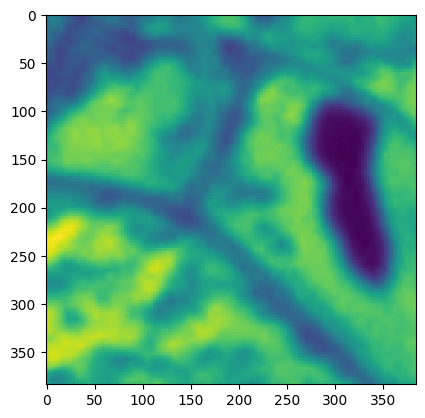

In [203]:
# What does one image and corresponding label look like?
dataset = gdal.Open(train_images_paths[1605])
band = dataset.GetRasterBand(4) # band 4 to show NIR
array = band.ReadAsArray()
print(array.shape)
plt.imshow(array)

(384, 384)


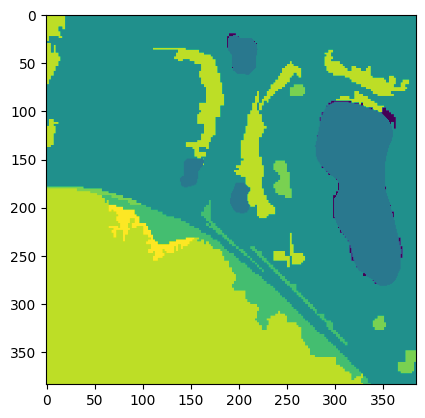

In [204]:
# What does one image and corresponding label look like?
dataset = gdal.Open(train_labels_paths[1605])
band = dataset.GetRasterBand(1) # band 1 bc there is only 1 band
array = band.ReadAsArray()
print(array.shape)
plt.imshow(array)

In [256]:
# Used this one to predict model_1year_0329_05 (50 epochs) with multi_unet_model to build model


class DataGenerator(Sequence):
    def __init__(self, image_files, label_files, img_height, img_width, batch_size, num_classes):
        self.image_files = image_files
        self.label_files = label_files
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.num_classes = num_classes

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        image_batch_files = self.image_files[index * self.batch_size : (index + 1) * self.batch_size]
        label_batch_files = self.label_files[index * self.batch_size : (index + 1) * self.batch_size]

        batch_images, batch_labels = self.load_images_and_labels(image_batch_files, label_batch_files)
        return batch_images, batch_labels

    def load_and_reshape_image(self, image_path):
        with rasterio.open(image_path) as src:
            image = src.read().transpose((1, 2, 0))
            if image.shape[:2] != (self.img_height, self.img_width):
                image = cv2.resize(image, (self.img_width, self.img_height), interpolation=cv2.INTER_NEAREST)
        return image

    def z_score_normalization(self, image):
        image = image.astype(np.float32)  # Ensure the image is in float format to handle division and large ranges
        min_val = np.min(image, axis=(0, 1), keepdims=True)
        max_val = np.max(image, axis=(0, 1), keepdims=True)
        range_val = max_val - min_val
        if np.any(range_val == 0):
            normalized_image = np.zeros(image.shape, dtype=np.float32)
        else:
            normalized_image = (image - min_val) / range_val
        return normalized_image

    def load_images_and_labels(self, image_files, label_files):
        images = [self.load_and_reshape_image(image_file) for image_file in image_files]
        labels = [self.load_and_reshape_image(label_file) for label_file in label_files]
        normalized_images = [self.z_score_normalization(image) for image in images]
        processed_labels = [to_categorical(label, num_classes=self.num_classes) for label in labels]
        return np.array(normalized_images), np.array(processed_labels)

In [233]:
# # Used this one to predict model_1year_0329_02 (5 epochs)
# # Used this one to predict model_1year_0329_04 (50 epochs)
# class DataGenerator(Sequence):
#     def __init__(self, image_files, label_files, img_height, img_width, batch_size, num_classes):
#         self.image_files = image_files
#         self.label_files = label_files
#         self.img_height = img_height
#         self.img_width = img_width
#         self.batch_size = batch_size
#         self.num_classes = num_classes

#     def __len__(self):
#         return int(np.ceil(len(self.image_files) / self.batch_size))

#     def __getitem__(self, index):
#         image_batch_files = self.image_files[index * self.batch_size : (index + 1) * self.batch_size]
#         label_batch_files = self.label_files[index * self.batch_size : (index + 1) * self.batch_size]

#         batch_images, batch_labels = self.load_images_and_labels(image_batch_files, label_batch_files)
#         return batch_images, batch_labels

#     def load_and_reshape_image(self, image_path):
#         with rasterio.open(image_path) as src:
#             image = src.read().transpose((1, 2, 0))
#             if image.shape[:2] != (self.img_height, self.img_width):
#                 image = cv2.resize(image, (self.img_width, self.img_height), interpolation=cv2.INTER_NEAREST)
#         return image




#     def z_score_normalization(self, image):
#         # Normalize first four bands (spectral bands)
#         spectral_bands = image[:, :, :4]  # Assuming the last dimension is channels
#         min_spectral = np.min(spectral_bands, axis=(0, 1), keepdims=True)
#         max_spectral = np.max(spectral_bands, axis=(0, 1), keepdims=True)
#         range_spectral = max_spectral - min_spectral
#         if np.any(range_spectral == 0):
#             normalized_spectral_bands = np.zeros(spectral_bands.shape, dtype=np.float32)
#         else:
#             normalized_spectral_bands = (spectral_bands - min_spectral) / range_spectral

#         # normalized_spectral_bands = (spectral_bands - min_spectral) / (max_spectral - min_spectral)  THIS IS WHAT IT WAS BEFORE range_spectral and IF ELSE

#         # Handle the fifth band (elevation) separately
#         elevation_band = image[:, :, 4:]
#         min_elevation = np.min(elevation_band)
#         max_elevation = np.max(elevation_band)
#         range_elevation = max_elevation - min_elevation
#         if range_elevation == 0:
#             normalized_elevation_band = np.zeros(elevation_band.shape, dtype=np.float32)
#         else:
#             normalized_elevation_band = (elevation_band - min_elevation) / range_elevation


#         # Combine the normalized spectral bands and elevation band back into one array
#         normalized_image = np.concatenate((normalized_spectral_bands, normalized_elevation_band), axis=2)

#         return normalized_image

#         # elevation_band_no_nan = np.where(np.isnan(elevation_band),
#         #                                 np.nanmedian(elevation_band),
#         #                                 elevation_band)
#         # # Normalize elevation band
#         # # You might want to normalize it differently depending on your use case
#         # min_elevation = np.nanmin(elevation_band_no_nan)
#         # max_elevation = np.nanmax(elevation_band_no_nan)
#         # normalized_elevation_band = (elevation_band_no_nan - min_elevation) / (max_elevation - min_elevation)

#         # # Combine the normalized spectral bands and elevation band back into one array
#         # normalized_image = np.concatenate((normalized_spectral_bands, normalized_elevation_band), axis=2)

#         # return normalized_image



#   #  def z_score_normalization(self, image):
#   #       image = image.astype(np.float32)  # Ensure the image is in float format to handle division and large ranges
#   #       min_val = np.min(image, axis=(0, 1), keepdims=True)
#   #       max_val = np.max(image, axis=(0, 1), keepdims=True)
#   #       range_val = max_val - min_val
#   #       if np.any(range_val == 0):
#   #           normalized_image = np.zeros(image.shape, dtype=np.float32)
#   #       else:
#   #           normalized_image = (image - min_val) / range_val
#   #       return normalized_image




#     def load_images_and_labels(self, image_files, label_files):
#         images = [self.load_and_reshape_image(image_file) for image_file in image_files]
#         labels = [self.load_and_reshape_image(label_file) for label_file in label_files]

#         # Apply Z-score normalization to images
#         normalized_images = [self.z_score_normalization(image) for image in images]

#         # Process labels if necessary (for example, converting to categorical)
#         processed_labels = [to_categorical(label, num_classes=self.num_classes) for label in labels]

#         return np.array(normalized_images), np.array(processed_labels)

In [205]:
# # Used this one to predict model_1year_0329_03 (5 epochs)


# class DataGenerator(Sequence):
#     def __init__(self, image_files, label_files, img_height, img_width, batch_size, num_classes):
#         self.image_files = image_files
#         self.label_files = label_files
#         self.img_height = img_height
#         self.img_width = img_width
#         self.batch_size = batch_size
#         self.num_classes = num_classes

#     def __len__(self):
#         return int(np.ceil(len(self.image_files) / self.batch_size))

#     def __getitem__(self, index):
#         image_batch_files = self.image_files[index * self.batch_size : (index + 1) * self.batch_size]
#         label_batch_files = self.label_files[index * self.batch_size : (index + 1) * self.batch_size]

#         batch_images, batch_labels = self.load_images_and_labels(image_batch_files, label_batch_files)
#         return batch_images, batch_labels

#     def load_and_reshape_image(self, image_path):
#         with rasterio.open(image_path) as src:
#             image = src.read().transpose((1, 2, 0))
#             if image.shape[:2] != (self.img_height, self.img_width):
#                 image = cv2.resize(image, (self.img_width, self.img_height), interpolation=cv2.INTER_NEAREST)
#         return image

#     def z_score_normalization(self, image):
#         image = image.astype(np.float32)  # Ensure the image is in float format to handle division and large ranges
#         min_val = np.min(image, axis=(0, 1), keepdims=True)
#         max_val = np.max(image, axis=(0, 1), keepdims=True)
#         range_val = max_val - min_val
#         if np.any(range_val == 0):
#             normalized_image = np.zeros(image.shape, dtype=np.float32)
#         else:
#             normalized_image = (image - min_val) / range_val
#         return normalized_image

#     def load_images_and_labels(self, image_files, label_files):
#         images = [self.load_and_reshape_image(image_file) for image_file in image_files]
#         labels = [self.load_and_reshape_image(label_file) for label_file in label_files]
#         normalized_images = [self.z_score_normalization(image) for image in images]
#         processed_labels = [to_categorical(label, num_classes=self.num_classes) for label in labels]
#         return np.array(normalized_images), np.array(processed_labels)

In [257]:
SIZE_X = 384
SIZE_Y = 384
batch_size = 16
n_classes = 13

In [258]:
train_data_generator = DataGenerator(train_images_paths, train_labels_paths, SIZE_X, SIZE_Y, batch_size, n_classes)
val_data_generator = DataGenerator(val_images_paths, val_labels_paths, SIZE_X, SIZE_Y, batch_size, n_classes)

In [ ]:
# train_images_paths
# train_labels_paths

# val_images_paths
# val_labels_paths

In [259]:
batch_images, batch_labels = train_data_generator.__getitem__(0)

In [260]:
batch_images

array([[[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         

In [ ]:
batch_labels

In [ ]:
batch_labels

In [261]:
batch_images.shape

(16, 384, 384, 5)

In [262]:
batch_labels.shape

(16, 384, 384, 13)

In [263]:
# Used this one to predict model_1year_0329_05 (50 epochs) with the first listed dataGenerator in this code.

def multi_unet_model(n_classes=13, IMG_HEIGHT=384, IMG_WIDTH=384, IMG_CHANNELS=5): # change IMG_CHANNELS based on which year working with (5, 9, or 13)
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(s)
    c1 = BatchNormalization()(c1) # includes batch normalization after every conv
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = BatchNormalization()(u6)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(u6)
    u6 = BatchNormalization()(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c6)
    u6 = BatchNormalization()(u6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [264]:
model = multi_unet_model(n_classes=13, IMG_HEIGHT=384, IMG_WIDTH=384, IMG_CHANNELS=5)

In [239]:
# this was used for model_1year_0329, model_1year_0329_02, model_1year_0329_03, and model_1year_0329_04, NOT used fo r05

# from tensorflow import keras
# from tensorflow.keras import layers

# def get_model(img_size, num_classes):
#     inputs = keras.Input(shape=img_size + (5,))  # Add number of channels: 5

#     ### [First half of the network: downsampling inputs] ###

#     # Entry block
#     x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     previous_block_activation = x  # Set aside residual

#     # Blocks 1, 2, 3 are identical apart from the feature depth.
#     for filters in [64, 128, 256]:
#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

#         # Project residual
#         residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
#             previous_block_activation
#         )
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     ### [Second half of the network: upsampling inputs] ###

#     for filters in [256, 128, 64, 32]:
#         x = layers.Activation("relu")(x)
#         x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
#         x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.UpSampling2D(2)(x)

#         # Project residual
#         residual = layers.UpSampling2D(2)(previous_block_activation)
#         residual = layers.Conv2D(filters, 1, padding="same")(residual)
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     # Add a per-pixel classification layer
#     outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

#     # Define the model
#     model = keras.Model(inputs, outputs)
#     return model

# # Free up RAM in case the model definition cells were run multiple times
# keras.backend.clear_session()


In [240]:
# model = get_model(img_size=(SIZE_X, SIZE_Y), num_classes=13)

In [265]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 384, 384, 5), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [266]:
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 384, 384, 13), dtype=tf.float32, name=None), name='conv2d_27/Softmax:0', description="created by layer 'conv2d_27'")


In [267]:
print(model.summary()) # 1year: 2,062,445  with multi_unet_model 1946973

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 384, 384, 5)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 384, 384, 16)         736       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_15 (Ba  (None, 384, 384, 16)         64        ['conv2d_9[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 dropout (Dropout)           (None, 384, 384, 16)         0         ['batch_normalization_15

In [ ]:
# model = get_model(IMG_HEIGHT=SIZE_X, IMG_WIDTH=SIZE_Y, IMG_CHANNELS=5, n_classes=13)

In [268]:
import numpy as np
import cv2
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback
import rasterio
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard


class SavePredictionCallback(Callback):
    def __init__(self, test_image_dir, test_label_dir, model_input_size, output_folder, epoch_frequency=5):
        super().__init__()
        self.test_image_dir = test_image_dir
        self.test_label_dir = test_label_dir  # Optional: Use if you want to compare predictions with actual labels
        self.model_input_size = model_input_size
        self.output_folder = output_folder
        self.epoch_frequency = epoch_frequency
        self.image_files = [os.path.join(test_image_dir, f) for f in os.listdir(test_image_dir) if f.endswith('.tif')]

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epoch_frequency == 0:
            for image_path in self.image_files:
                with rasterio.open(image_path) as src:
                    image = src.read(out_shape=(src.count, self.model_input_size[0], self.model_input_size[1]),
                                     resampling=rasterio.enums.Resampling.nearest)
                    image = np.transpose(image, (1, 2, 0))
                    image = np.expand_dims(image, axis=0)  # Add batch dimension
                    image = image / np.max(image)  # Normalize
                    meta = src.meta

                prediction = self.model.predict(image)
                prediction_image = np.argmax(prediction, axis=-1)[0, :, :]

                output_path = os.path.join(self.output_folder, f"epoch_{epoch+1}_{os.path.basename(image_path)}")
                meta = src.meta
                meta.update(dtype=rasterio.uint8, count=1, nodata=None)  # what was here previously: (dtype=rasterio.uint8, count=1)

                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(prediction_image.astype(rasterio.uint8), 1)

# Define model input size and paths

IMG_HEIGHT, IMG_WIDTH = SIZE_X, SIZE_Y
test_image_dir = '/content/drive/MyDrive/data/model_template/x_test/x_test_1year/'
test_label_dir = '/content/drive/MyDrive/data/model_template/y_test/'  # Optional
output_folder = '/content/drive/MyDrive/data/model_outputs/model_1year_0329_05/'

# Make sure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# Instantiate the callback
save_pred_callback = SavePredictionCallback(
    test_image_dir=test_image_dir,
    test_label_dir=test_label_dir,
    model_input_size=(IMG_HEIGHT, IMG_WIDTH),
    output_folder=output_folder,
    epoch_frequency=5
)

In [269]:
model.compile(optimizer= Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', "categorical_accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/data/model_outputs/model_1year_0329_05/model_1year_0329_05.h5', monitor = 'val_loss', save_best_only=True),
    save_pred_callback
]
Tensor_Board = tf.keras.callbacks.TensorBoard('/content/drive/MyDrive/data/model_outputs/model_1year_0329_05/model_1year_0329_05/run_logs')

In [270]:
model.fit(train_data_generator, validation_data= val_data_generator, epochs=50, callbacks=[callbacks, Tensor_Board],shuffle=True)

Epoch 1/50
  6/116 [>.............................] - ETA: 2:18 - loss: 2.8761 - accuracy: 0.0519 - categorical_accuracy: 0.0519

116/116 [==============================] - 263s 2s/step - loss: 2.3740 - accuracy: 0.3067 - categorical_accuracy: 0.3067 - val_loss: 4.1477 - val_accuracy: 0.1202 - val_categorical_accuracy: 0.1202
Epoch 2/50
116/116 [==============================] - 201s 2s/step - loss: 2.1242 - accuracy: 0.3767 - categorical_accuracy: 0.3767 - val_loss: 2.0571 - val_accuracy: 0.3858 - val_categorical_accuracy: 0.3858
Epoch 3/50
116/116 [==============================] - 190s 2s/step - loss: 1.9871 - accuracy: 0.4056 - categorical_accuracy: 0.4056 - val_loss: 2.0138 - val_accuracy: 0.2866 - val_categorical_accuracy: 0.2866
Epoch 4/50
116/116 [==============================] - 203s 2s/step - loss: 1.8921 - accuracy: 0.4147 - categorical_accuracy: 0.4147 - val_loss: 1.7662 - val_accuracy: 0.4447 - val_categorical_accuracy: 0.4447
Epoch 5/50
116/116 [==============================] - 212s 2s/step - loss: 1.8187 - accuracy: 0.4271 - categorical_accuracy: 0.4271 - val_loss: 2.2290 - val_accuracy: 0.3798 -

In [271]:
from tensorflow.keras.models import load_model

# Replace 'path/to/your/model.h5' with the actual path to your saved model
model = load_model('/content/drive/MyDrive/data/model_outputs/model_1year_0329_05/model_1year_0329_05.h5')

In [225]:
# pip install matplotlib

In [272]:
from tensorflow.image import resize

def load_and_preprocess_image(image_path, expected_size):
    with rasterio.open(image_path) as src:
        # Read the imagery tile, assuming it's multi-band
        image = src.read()
        if image.shape[0] > 5:
            image = image[:5, :, :]
        image = np.transpose(image, (1, 2, 0))
        image = resize(image, [expected_size, expected_size])

        p2, p98 = np.percentile(image, (2, 98))
        image = np.clip(image, p2, p98)
        image = image / np.max(image)
        image = np.expand_dims(image, axis=0)

        # image = image / 2555.0  # Adjust based on your normalization method
        # image = np.expand_dims(image, axis=0)
        return image

image_path = '/content/drive/MyDrive/data/model_template/x_test/x_test_1year/2118_planet_stack_utm4.tif'
expected_size = 384
image = load_and_preprocess_image(image_path, expected_size)

In [273]:
prediction = model.predict(image)
predicted_mask = np.argmax(prediction, axis=-1)
predicted_mask = predicted_mask[0, :, :]
predicted_mask

1/1 [==============================] - 1s 679ms/step


array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [10, 10, 10, ...,  1,  1,  1],
       [10, 10, 10, ...,  3,  3,  1],
       [10, 10, 10, ...,  1,  1,  1]])

In [274]:
# Find unique values in the band data
predicted_mask_unique = np.unique(predicted_mask)
print("Unique classes:", predicted_mask_unique)

Unique classes: [ 1  3  6 10]


1/1 [==============================] - 1s 881ms/step


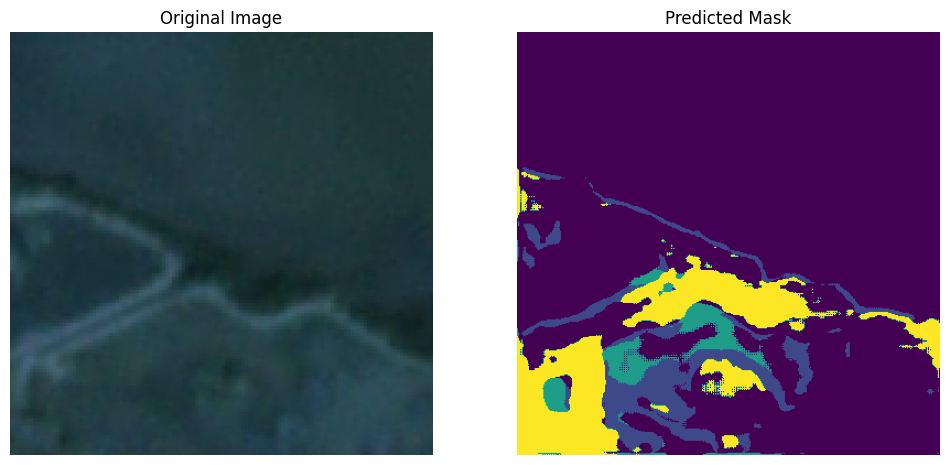

In [275]:
import matplotlib.pyplot as plt

def visualize_prediction(original_image, predicted_mask, figsize=(12, 6)):
    # If the original image has more than 3 channels, select the first three for visualization
    if original_image.shape[-1] > 3:
        original_image = original_image[:, :, :3]

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    # Display the original image
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    # Display the predicted mask
    # Assuming predicted_mask is 2D (height, width), you might want to add a colormap
    axes[1].imshow(predicted_mask, cmap='viridis')  # Use a colormap that suits your task
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')
    plt.show()

prediction = model.predict(image)

# Convert prediction to a class mask
predicted_mask = np.argmax(prediction, axis=-1)[0, :, :]  # Remove batch dimension
adjusted_image = np.clip(image, 0, 1)  # Ensure values are within [0, 1]
visualize_prediction(adjusted_image[0], predicted_mask)


In [251]:
def predict_and_save(model, test_image_dir, model_input_size, output_folder):
    image_files = [os.path.join(test_image_dir, f) for f in os.listdir(test_image_dir) if f.endswith('.tif')]

    for image_path in image_files:
        with rasterio.open(image_path) as src:
            image = src.read(out_shape=(src.count, model_input_size[0], model_input_size[1]),
                             resampling=rasterio.enums.Resampling.nearest)
            image = np.transpose(image, (1, 2, 0))
            image = np.expand_dims(image, axis=0)  # Add batch dimension
            # image = image / np.max(image)  # Normalize
            image = image / 2555.0

            prediction = model.predict(image)
            prediction_image = np.argmax(prediction, axis=-1)[0, :, :]
            meta = src.meta
            # meta.update(dtype=rasterio.uint8, count=1)
            meta.update(dtype=rasterio.uint8, count=1, nodata=None)



            output_path = os.path.join(output_folder, f"prediction_{os.path.basename(image_path)}")
            with rasterio.open(output_path, 'w', **meta) as dst:
                dst.write(prediction_image.astype(rasterio.uint8), 1)

In [276]:
# Define model input size and paths
IMG_HEIGHT, IMG_WIDTH = SIZE_X, SIZE_Y  # Ensure these are defined or replace them with actual values
test_image_dir = '/content/drive/MyDrive/data/model_template/x_test/x_test_1year/'
output_folder = '/content/drive/MyDrive/data/model_outputs/model_1year_0329_05/'

# /content/drive/MyDrive/DeepLearning_Project/planet_TwoYear/test_dataset/model_03222024_1255/model_03222024_1255.h5

# Make sure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# Execute prediction and saving
predict_and_save(model, test_image_dir, (IMG_HEIGHT, IMG_WIDTH), output_folder)

1/1 [==============================] - 0s 37ms/step
